Date : June 15  
Author : Ashok

The following three cells are taken from the "Carroll4th Cloud Coverage Data-Copy1.ipynb" present [here](https://github.com/floodnet-nyc/Solar-Coverage-Data/blob/main/Carroll4th%20Cloud%20Coverage%20Data-Copy1.ipynb) but are modified to query data for any number of days one wants to. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib3
urllib3.disable_warnings()
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write.retry import WritesRetry
from influxdb_client.client.write_api import SYNCHRONOUS
import geocoder
import glob
from influxdb_client.domain.write_precision import WritePrecision
from datetime import datetime, timedelta

sns.set(rc = {'figure.figsize':(18,10)})
%config InlineBackend.figure_format = 'retina'

In [2]:
def query_from_influxdb(_url=None,
                        _token=None,
                        _org=None,
                        _id=None,
                        _bucket_name=None,
                        _columns_to_drop=None,
                        _measurement=None,
                        _field=None,
                       _start = None):

    """
        Function to query InfluxDB using influxdb-python-client library from https://github.com/influxdata/influxdb-client-python
            :param _measurement: Available options are flood-sensor-tidal-sensor-rain-gauge,weather,etc. Default is flood-sensor
            :param _field: Available options include batt_v and cloud_percent
            :param _url: InfluxDB url
            :param _token: API token with read-access
            :param _org: InfluxDB organization name
            :param _id: Sensor/Deployment ID
            :param _bucket_name: Name of the bucket
            :param _columns_to_drop: Array-like column names to be dropped
            :param _start : Start time for the query,type : datetime
        :returns a dataframe with all columns except dropped ones if any
    """
    result = []

    p = {"_id_value": _id,
         "_bucket_name": _bucket_name,
         "_measurement": _measurement,
         "_field": _field,
        "_start": _start
        }


    with InfluxDBClient(url=_url, token=_token, org=_org, timeout=1000000, verify_ssl = False) as client:
        query_api = client.query_api()
        if _measurement=="weather":
            result = query_api.query_data_frame('''from(bucket: _bucket_name)
                                                  |> range(start: _start, stop: now())
                                                  |> filter(fn: (r) => r["_measurement"] == _measurement)
                                                  |> filter(fn: (r) => r["_field"] == _field)
                                                  |> filter(fn: (r) => r["sensor_id"] == _id_value)
                                                  |> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
                                                ''', params=p)
        else:
            result = query_api.query_data_frame('''from(bucket: _bucket_name)
                                                |> range(start: _start)
                                                |> filter(fn: (r) => r["_measurement"] == _measurement)
                                                |> filter(fn: (r) => r["deployment_id"] == _id_value)
                                                |> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
                                                ''', params=p)

        if type(result) == list:
            result = pd.concat(result)

    result.drop(columns=['_start', '_stop', 'result', 'table'], inplace=True) #result
    result.rename(columns={'_time': 'time', '_measurement': 'measurement'}, inplace=True)
    result['time'] = pd.to_datetime(result['time'], format="%Y-%m-%d %H:%M:%S.%f", utc=True)
    result.set_index('time', inplace=True)
    result = result.sort_values(by=['time'])

    return result

In [4]:
start_day = 30 ##number of days for which you want to get the data 

# Get the current date and time
current_datetime = datetime.now()

# Calculate the date and time exactly start_days days ago
start_time = current_datetime - timedelta(days = start_day)

# Getting the deployment id
sensor_location_data = pd.read_csv("Sensor Locations Directory - Internal - street sensors (live).csv")

for deployment_id in sensor_location_data['deployment_id']:
    try:
        retrived_df= query_from_influxdb(_url='https://influxdb.floodlabs.nyc/',
                           _token='rvEpEpb9bDwrb1NbmlbnmT4HT_XCQxeKn3DHghJu9uABrm1qbHhR9D8eXsoMux9v073wttFRY6FLs6FxM7TuSw==',
                       _org='floodnet',
                       _id= deployment_id,
                      _bucket_name='floodnet-live',
                       _measurement="flood-sensor",
                        _start = start_time,
                       _field="batt_v",).reset_index()[['time', 'batt_v', 'depth_filt_mm', 'dist_mm', 'f_cnt', 'gw_1_rssi_dbm', 'gw_1_snr_db','gw_2_rssi_dbm', 'gw_2_snr_db','gw_3_rssi_dbm', 'gw_3_snr_db','deployment_id']]


        retrived_df['times'] = retrived_df['time'].dt.time
        retrived_df['date'] = retrived_df['time'].dt.date

        file_path = deployment_id + ".csv"
        retrived_df.to_csv(file_path)
        print("saved" + file_path)
    except KeyError:
        pass

saveddaily_gentle_beetle.csv
savedoverly_heroic_squid.csv
savedweekly_poetic_guinea.csv
savedvastly_saving_whale.csv
savedopenly_driven_tarpon.csv
savedjolly_tender_squid.csv
saveddaily_new_falcon.csv
savedgladly_mint_snail.csv
savedeasily_dear_mouse.csv
savedbored_blue_fish.csv
saveddaily_happy_satyr.csv
savedmean_flying_fish.csv
savedclosed_wagon_snail.csv
savedclearly_bored_turtle.csv
savedblue_eyed_tiger.csv
savedsimply_half_monkey.csv
savedtotal_melt_deer.csv
savedlight_maroon_penguin.csv
savedlovely_helped_lamb.csv
saveddaily_ace_bear.csv


<AxesSubplot:xlabel='time', ylabel='depth_filt_mm'>

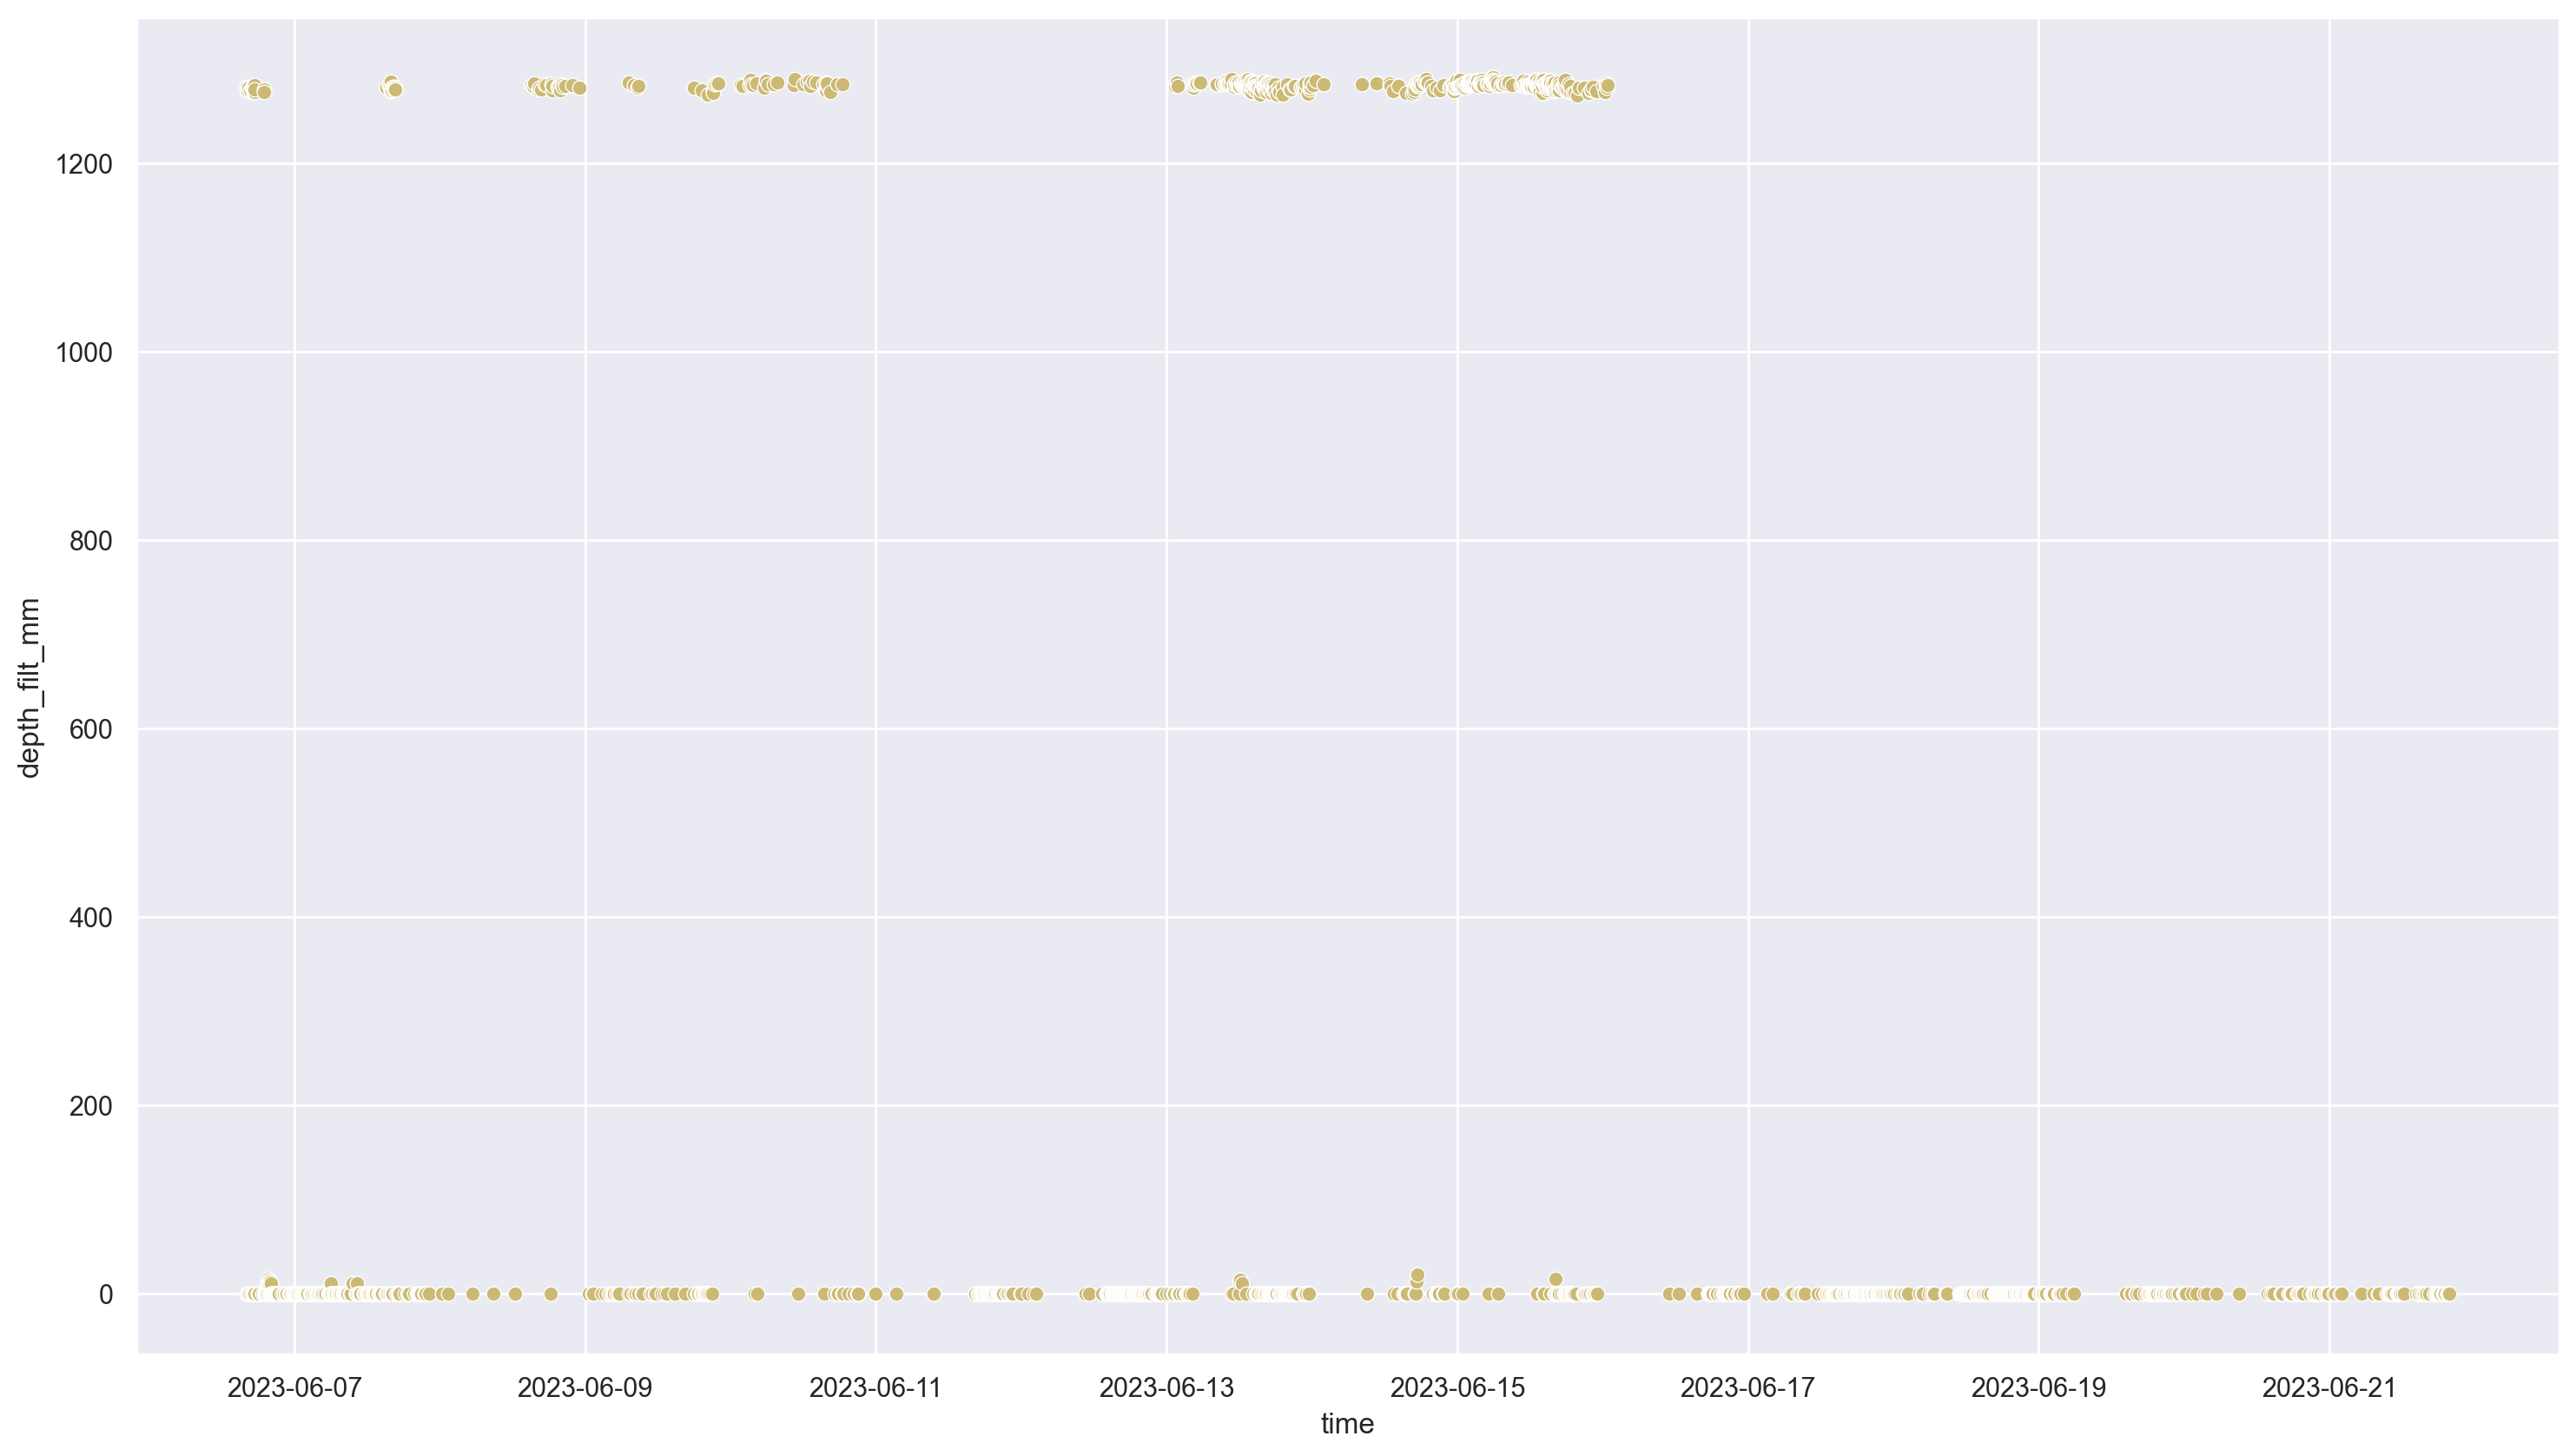

In [56]:

sns.scatterplot(x = "time", y = "depth_filt_mm", color = 'y', data = retrived_df)
  

<AxesSubplot:xlabel='time', ylabel='smooth_rssi'>

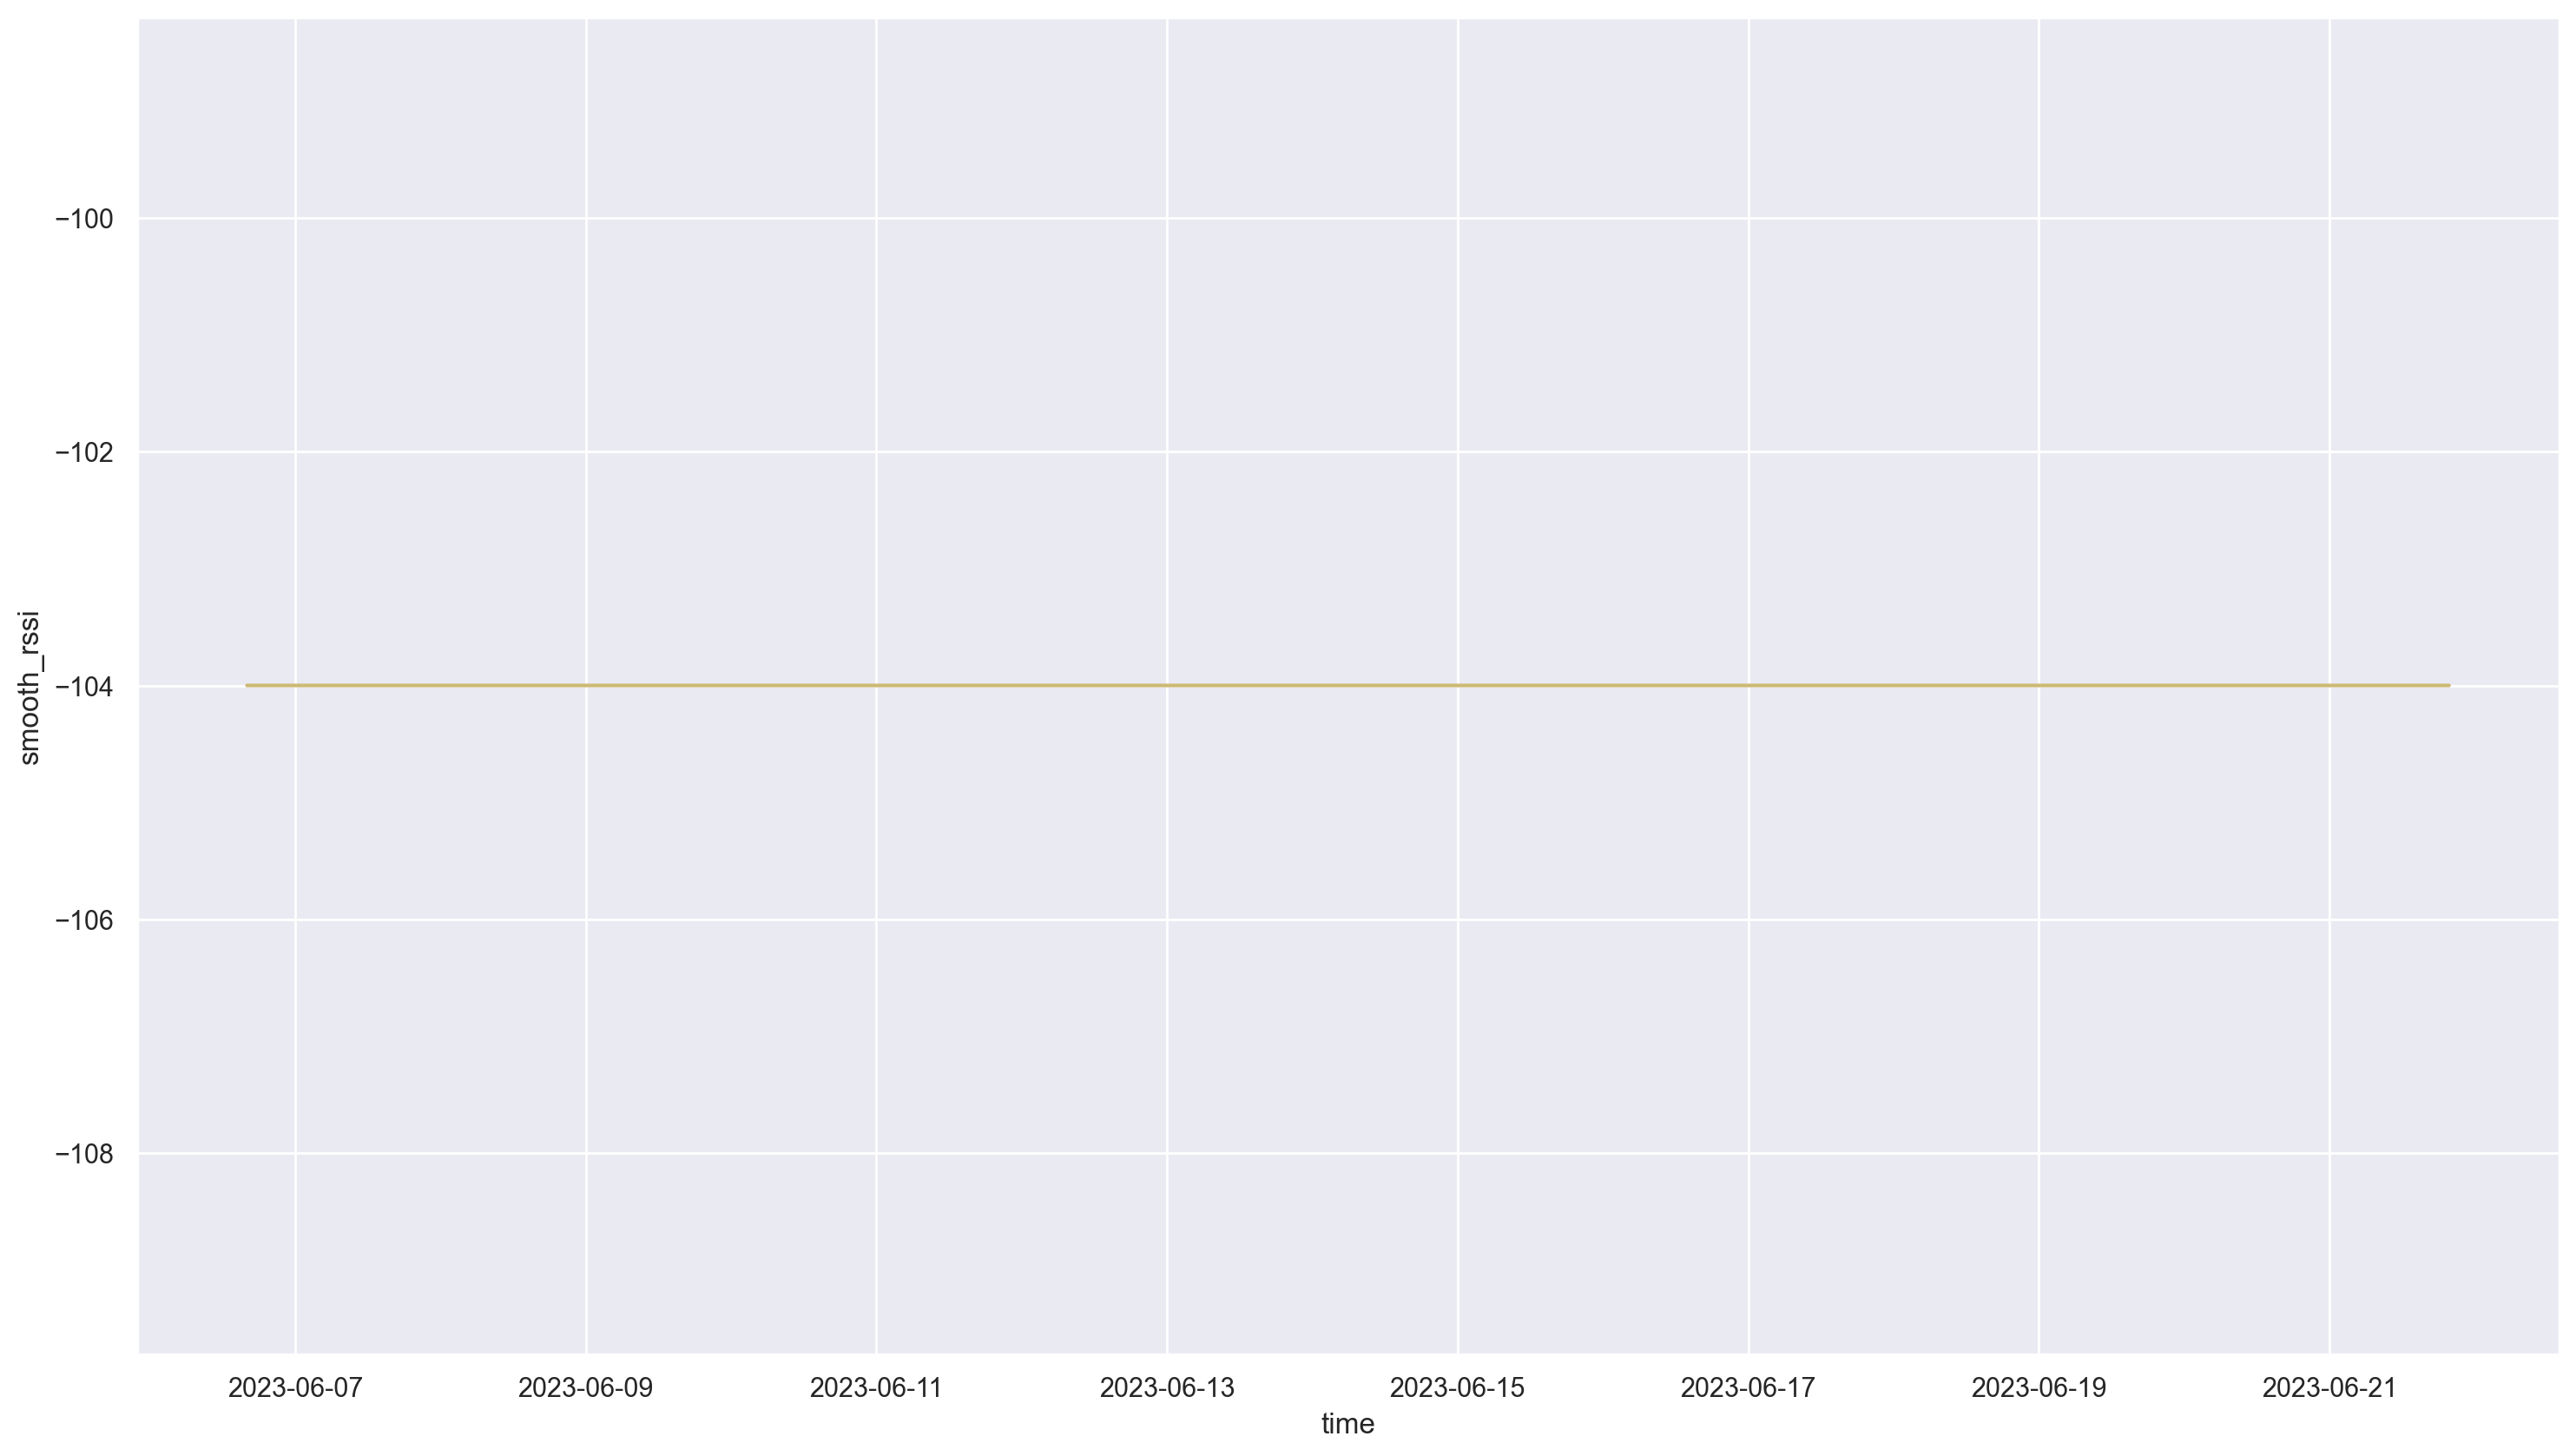

In [57]:
!pip install scipy
from scipy.ndimage import gaussian_filter1d
retrived_df['smooth_rssi'] = gaussian_filter1d(retrived_df['gw_1_rssi_dbm'], sigma=1000)
sns.lineplot(x = "time", y = "smooth_rssi", color = 'y', data = retrived_df)

In [58]:
retrived_df['datetime'] = pd.to_datetime(retrived_df['time'])
# retrived_df['datetime']

retrived_df['times'] = retrived_df['time'].dt.time
retrived_df['date'] = retrived_df['time'].dt.date